In [1]:
# Drive is assumed to be already mounted

In [2]:
import os
import sys
import torch
import numpy as np

In [3]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

! pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# ! pip install ogb==1.3.2  # to download ogbg datasets

# In case future versions of PyTorch or PyTorch-Geometric do not fit current code, use the following instead to install them, which may take a while.
# ! pip install torch==1.10.0+cu113 torchvision -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install torch-scatter==2.0.9 torch-sparse==0.6.12 torch-cluster==1.5.9 torch-spline-conv==1.2.1 torch-geometric==2.0.3 -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 9.9 MB/s 
     |████████████████████████████████| 4.6 MB 1.7 MB/s 
     |████████████████████████████████| 280 kB 4.2 MB/s 


In [5]:
BASE_DIR = "/content/drive/MyDrive/cs593_clg/src"
sys.path.append(BASE_DIR)
data_dir = f"{BASE_DIR}/data"
cuda_id = 0
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

In [6]:
from data_loader import SynGraphDataset
import torch_geometric
import networkx as nx

## Data Loading

In [7]:
dataset_name = 'tree_cycle'  # ba_shapes, ba_community, tree_cycle, tree_grid

In [8]:
dataset = SynGraphDataset(data_dir, dataset_name)

## uncomment below to visualize graph (but many nodes so often not very helpful)
# g_nx = torch_geometric.utils.to_networkx(dataset.data, to_undirected=True)
# nx.draw(g_nx)

In [9]:
NUM_CLASSES = dataset.num_classes
NUM_NODE_FEATS = dataset.num_node_features
print(dataset.data)
print(NUM_CLASSES)

Data(x=[871, 10], edge_index=[2, 1942], y=[871], train_mask=[871], val_mask=[871], test_mask=[871])
2


In [10]:
dataset.get_summary()

SynGraphDataset (#graphs=1):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |      871 |     1942 |
| std        |      nan |      nan |
| min        |      871 |     1942 |
| quantile25 |      871 |     1942 |
| median     |      871 |     1942 |
| quantile75 |      871 |     1942 |
| max        |      871 |     1942 |
+------------+----------+----------+

## GNNExplainer and PGExplainer

In [11]:
# task = 'node'
# explainer_type = 'GNN'  # PG or GNN
# load_pretrained = True
# model = NodeGCN(NUM_NODE_FEATS, NUM_CLASSES)
# graphs = dataset.data.edge_index
# features = dataset.data.x
# labels = dataset.data.y

# if load_pretrained:
#   path = f"{BASE_DIR}/ExplanationEvaluation/models/pretrained/{explainer_type}/{dataset_name}/best_model"
#   checkpoint = torch.load(path)
#   model.load_state_dict(checkpoint['model_state_dict'])

# if explainer_type == 'PG':
#   explainer = PGExplainer(model, graphs, features, task)
# else:
#   explainer = GNNExplainer(model, graphs, features, task)

# # select some nodes (by index) for qualitative explain
# indices = range(400, 700, 5)
# explainer.prepare(indices)

# for idx in indices:
#   graph, expl = explainer.explain(idx)
#   plot(graph=graph, edge_weigths=expl, labels=labels, idx=idx, 
#        thres_min=12, thres_snip=100, dataset=dataset_name, show=True)

In [12]:
from ExplanationEvaluation.models.GNN_paper import NodeGCN
from ExplanationEvaluation.explainers.PGExplainer import PGExplainer
from ExplanationEvaluation.explainers.GNNExplainer import GNNExplainer
from ExplanationEvaluation.utils.plotting import plot
from ExplanationEvaluation.datasets.ground_truth_loaders import load_dataset_ground_truth
from ExplanationEvaluation.evaluation.AUCEvaluation import AUCEvaluation
from ExplanationEvaluation.evaluation.EfficiencyEvaluation import EfficiencyEvluation
from ExplanationEvaluation.tasks.replication import run_experiment

In [13]:
task = 'node'
explainer_type = 'GNN'  # PG or GNN
# name of dataset in implementation that reproduces GNNExplainer and PGExplainer
dataset_name_re_dict = {
  'ba_shapes': 'syn1', 
  'ba_community': 'syn2', 
  'tree_cycle': 'syn3', 
  'tree_grid': 'syn4'
}
dataset_name_re = dataset_name_re_dict[dataset_name]

In [14]:
# will be using existing implementation: https://github.com/LarsHoldijk/RE-ParameterizedExplainerForGraphNeuralNetworks
# thus need to reformat data
graphs = dataset.data.edge_index
features = dataset.data.x
labels = dataset.data.y

871

In [20]:
### TEMP
# !pip install -r /content/drive/MyDrive/cs593_clg/src/ExplanationEvaluation/requirements.txt
###
import torch_geometric as ptgeom
# for i in range(dataset.data.num_nodes):
g_temp = ptgeom.utils.k_hop_subgraph(2, 3, graphs)
g_temp

(tensor([  0,   1,   2,   3,   4,   5,   6,  11,  12,  13,  14,  23,  24,  25,
          26,  27,  28,  29,  30, 511, 512, 513, 514, 515, 516]),
 tensor([[  0,   0,   0,   1,   1,   1,   2,   2,   2,   2,   3,   4,   5,   5,
            5,   6,   6,   6,  11,  11,  11,  12,  12,  12,  13,  13,  13,  14,
           14,  14,  23,  24,  25,  26,  27,  28,  29,  30, 511, 511, 511, 512,
          512, 513, 513, 513, 514, 514, 515, 515, 516, 516],
         [  1,   2, 511,   0,   3,   4,   0,   5,   6, 513,   1,   1,   2,  11,
           12,   2,  13,  14,   5,  23,  24,   5,  25,  26,   6,  27,  28,   6,
           29,  30,  11,  11,  12,  12,  13,  13,  14,  14,   0, 512, 516, 511,
          513,   2, 512, 514, 513, 515, 514, 516, 511, 515]]),
 tensor([2]),
 tensor([ True,  True,  True,  ..., False, False, False]))

In [25]:
dataset.data.batch

In [ ]:
model = NodeGCN(NUM_NODE_FEATS, NUM_CLASSES) 
path = f"{BASE_DIR}/ExplanationEvaluation/models/pretrained/{explainer_type}/{dataset_name_re}/best_model"
checkpoint = torch.load(path)

try:
  model.load_state_dict(checkpoint['model_state_dict'])
# TODO: Manual correction for some models done only. Either use an earlier PyG version or come up with some better fix
# Still need to verify correct model loading
except:
  # https://github.com/pyg-team/pytorch_geometric/discussions/3171
  # NOTE: need to transpose weights as well
  checkpoint['model_state_dict']["conv1.lin.weight"] = checkpoint['model_state_dict']["conv1.weight"].T
  checkpoint['model_state_dict']["conv2.lin.weight"] = checkpoint['model_state_dict']["conv2.weight"].T
  checkpoint['model_state_dict']["conv3.lin.weight"] = checkpoint['model_state_dict']["conv3.weight"].T
  del checkpoint['model_state_dict']["conv1.weight"]
  del checkpoint['model_state_dict']["conv2.weight"]
  del checkpoint['model_state_dict']["conv3.weight"]
  model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# loading model above, but could also alternately train it

In [ ]:
if explainer_type == 'PG':
  explainer = PGExplainer(model, graphs, features, task)
else:
  explainer = GNNExplainer(model, graphs, features, task)

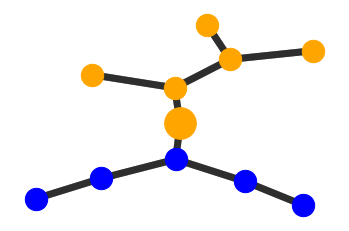

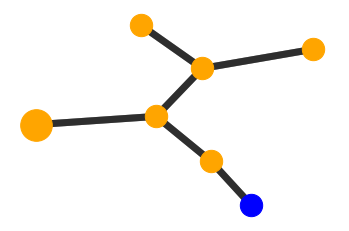

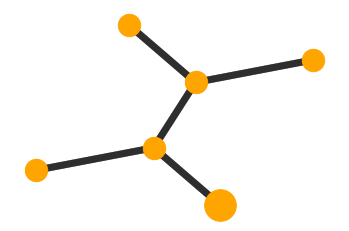

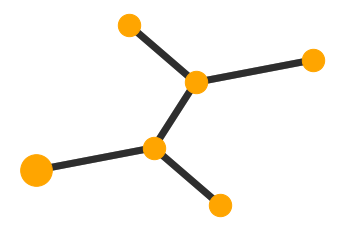

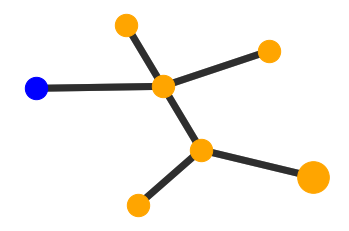

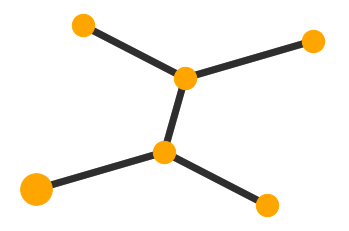

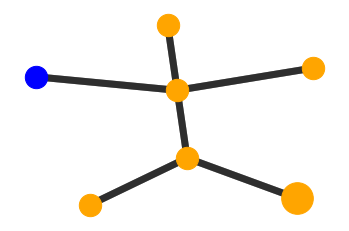

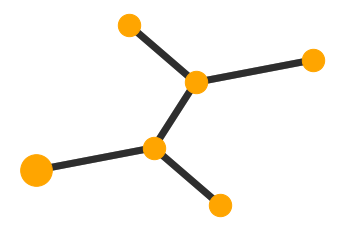

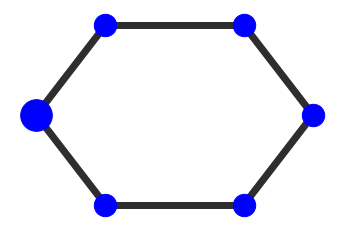

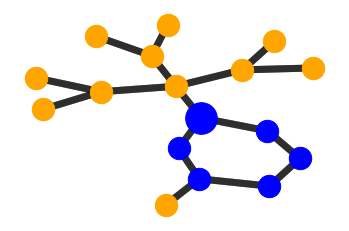

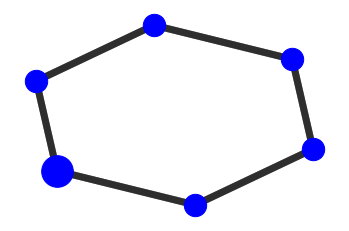

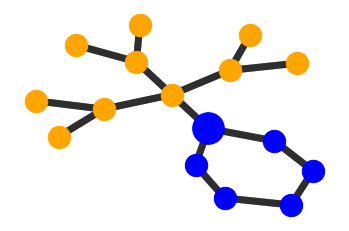

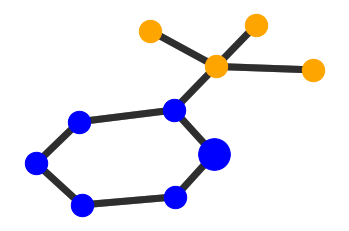

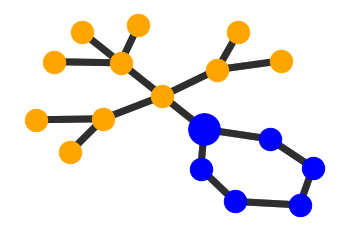

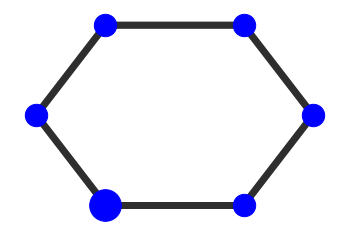

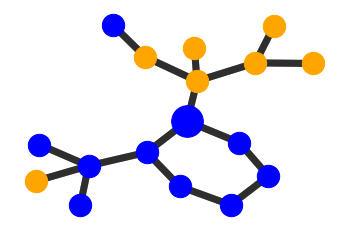

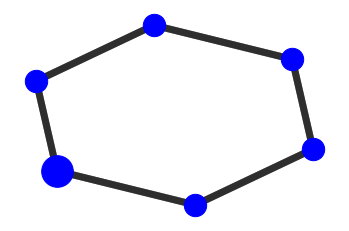

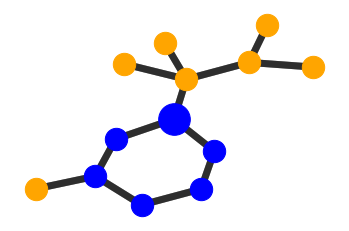

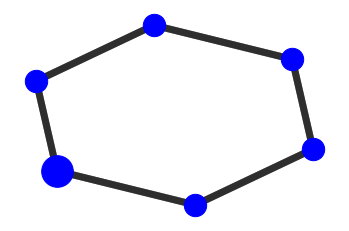

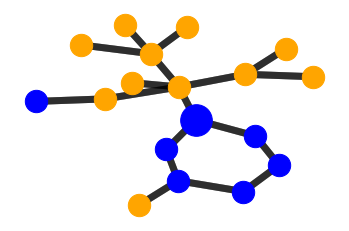

In [ ]:
# select some nodes (by index) for qualitative explain
# let's use the same indices as used in the original paper
# should ideally iterate only over test or validation nodes?
indices = range(400, 700, 15)
explainer.prepare(indices)

for idx in indices:
  graph, expl = explainer.explain(idx)
  # :param thresh_min: total number of edges
  # :param thres_snip: number of top edges
  plot(graph=graph, edge_weigths=expl, labels=labels, idx=idx, 
       thres_min=12, thres_snip=100, dataset=dataset_name_re, show=True)

In [ ]:
# more objective evaluation
explanation_labels, indices = load_dataset_ground_truth(dataset_name_re)

auc_evaluation = AUCEvaluation(task, explanation_labels, indices)
inference_eval = EfficiencyEvluation()

auc, time = run_experiment(inference_eval, auc_evaluation, explainer, indices)
print(auc)
print(time)

100%|██████████| 60/60 [00:11<00:00,  5.12it/s]


0.5050841716044279
195.42325337727866


In [ ]:
# ## TODO: Implementation not vetted properly
# # model predictive accuracy for reference
# clf_forward = model.forward(features, graphs)
# clf_logits = torch.nn.Softmax(dim=1)(clf_forward)
# clf_preds = clf_logits.argmax(dim=1)

# clf_acc = (labels == clf_preds).float().mean()
# print(f"Accuracy: {clf_acc}")

# # to verify that model (predictions) are reasonable
# # predicting all 0s in case PGExplainer so may not have a great model (or a bug in model files transfer/loading)
# print(np.unique(labels, return_counts=True))
# print(np.unique(clf_preds, return_counts=True))

In [ ]:
# some inconsistency between what I get and what is being reported
print(f"This model obtained: Train Acc: {checkpoint['train_acc']:.4f}, Val Acc: {checkpoint['val_acc']:.4f}, Test Acc: {checkpoint['test_acc']:.4f}.")

This model obtained: Train Acc: 0.9696, Val Acc: 1.0000, Test Acc: 1.0000.


## GSAT